<a href="https://colab.research.google.com/github/helmana/DLeeg/blob/master/NO_ort_3_ch_O12z___50_epoch_stopping_proposed_model_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
'''
>> Orthogonal best channel

109 subject
3 channel: [61,40,10] (Oz,T7,Cz)
task: REO 
epoch: 47
seed = 14

*outer_sample_shift = 8  # outer step len

TrainResult ([loss , acc])= [0.0001845475253316307, 0.9999582219251337]
ValidationResult ([loss , acc])= [0.0002473582127113868, 0.9999477424749164]
TestResult ([loss , acc])= [0.0006355660326044899, 0.9997667910447762]

'''


'\n>> Orthogonal best channel\n\n109 subject\n3 channel: [61,40,10] (Oz,T7,Cz)\ntask: REO \nepoch: 47\nseed = 14\n\n*outer_sample_shift = 8  # outer step len\n\nTrainResult ([loss , acc])= [0.0001845475253316307, 0.9999582219251337]\nValidationResult ([loss , acc])= [0.0002473582127113868, 0.9999477424749164]\nTestResult ([loss , acc])= [0.0006355660326044899, 0.9997667910447762]\n\n'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/4AEcIxVRCqBBNr5Vm40PXM_INhXruWF5V1THpEKpbxRUegzYFLDLl34
Mounted at /content/drive


In [3]:
!pip install mne

     |████████████████████████████████| 6.6MB 2.7MB/s 


In [4]:
'''
Rivision:
980806:
  First version.
  
  

'''

'\nRivision:\n980806:\n  First version.\n  \n  \n\n'

In [5]:
# Parameters:

EpochNum=150
subject_number=109
RemoveBaseLine=0
Orthogonal=1
task_index = [1] # task: REO
list_channel=[61,40,10]  #Oz
ch_number=len(list_channel)
TryStr='Try1'
seed = 14

task_number=1
task_time = 60
sampel_number_per_sec =  160 # sampel rate
total_sampel_number =  sampel_number_per_sec *task_time # 60*160
#sample_shift = 4 #step len
inner_sample_shift = 4 # inner step len
outer_sample_shift =8  # outer step len
window_len= 20
batch_size=64


In [6]:
# For Visualization
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa

# General use
import itertools
from itertools import combinations 

import os.path
from scipy.spatial import distance
import numpy as np
import math
import random
import datetime
import time
import pytz
from time import gmtime, strftime
import statistics

# General use
import itertools
from itertools import combinations 
import statistics
import csv
import os.path
from scipy.spatial import distance
import numpy as np
import math
import random
import datetime
import time
import pytz
from time import gmtime, strftime
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score


# For model training
from keras import layers
from keras import models
from keras import regularizers
from keras.utils import to_categorical
from keras import optimizers
from keras import backend as KerasBackend
from keras.models import load_model
from keras import backend as KerasBackend
from keras.callbacks import EarlyStopping,ModelCheckpoint



# EEG Tools
import mne
from mne.preprocessing import create_ecg_epochs, create_eog_epochs
from mne import io
from mne import viz
from mne import Epochs, io, pick_types
from mne.event import define_target_events
from mne.time_frequency import psd_welch
print(__doc__)



Automatically created module for IPython interactive environment


In [7]:
# load dataset in array
task_number= len(task_index)

# load dataset in array
list_raw_fnames = [[0]*task_number]*subject_number
for x in range(subject_number):
  list_raw_fnames[x] = mne.datasets.eegbci.load_data(x+1,task_index,path='/content/drive/My Drive/Deep Results/Database')

list_rawdata = np.zeros((subject_number,task_number), dtype='object')

for i in range(subject_number):
  for j in range(task_number):
    list_rawdata[i][j] = mne.io.read_raw_edf(list_raw_fnames[i][j], preload=True)


Do you want to set the path:
    /content/drive/My Drive/Deep Results/Database
as the default EEGBCI dataset path in the mne-python config [y]/n? y
Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
Extracting EDF parameters from /content/drive/My Drive/Deep Results/Database/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from /content/drive/My Drive/Deep Results/Database/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from /content/drive/My Drive/Deep Results/Database/MNE-eegbci-data/files/eegmmidb/1.0.0/S003/S003R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 

In [13]:
# img for each subject
subject_img_number = math.floor((total_sampel_number - sampel_number_per_sec - (window_len-1 )*inner_sample_shift) / outer_sample_shift) +1
np.random.seed(seed)  

subject_number_array_shuffled=np.arange(subject_number)
np.random.shuffle(subject_number_array_shuffled)

subject_img_number_array_shuffled=np.arange(subject_img_number)
np.random.shuffle(subject_img_number_array_shuffled)

train_index = math.floor(len(subject_img_number_array_shuffled)* 0.75)
val_index = train_index + (train_index//5)

train_shuff = subject_img_number_array_shuffled[:train_index]
val_shuff = subject_img_number_array_shuffled[train_index:val_index]
test_shuff = subject_img_number_array_shuffled[val_index:]


train_number = len(train_shuff)
val_number = len(val_shuff)
test_number = len(test_shuff)
print(train_number , val_number , test_number)
subject_img_number

878 175 118


1171

In [14]:
def normalize_channel_data(ch , i, ch_min, ch_max):
  ch = ((ch - ch_min[i]) / (ch_max[i] - ch_min[i] ))
  return ch

def ProjectionVector(VecA,VecB):
    Projeted_VecB_on_VecA=np.dot(VecA,VecB)/np.dot(VecA,VecA)*VecA
    return Projeted_VecB_on_VecA

In [15]:
#################################################################################################
## Define General Data Generator
def GenerateGeneralData(BatchSize,ListRawDataMain,SubjectArrayShuffled,ListChannel,RemoveBaseLineFlag,OrthogonalFlag,ImageArrayShuffled,WindowLen,OuterSampleShift,InnerSampleShift,SampelNumberPerSec):
    
    Iter=0
    #ch_number=len(ListChannel)
    
    
    ##########################################################
    # Pre-Proceesing On Raw Data
    ListRawDataTemp=ListRawDataMain.copy()
    
    DataAllChannelsRawPerSubject, times =(ListRawDataTemp[0][0][:64,:9600])

    DataChannelsRaw   =np.zeros((len(SubjectArrayShuffled),ch_number,times.size),dtype = float)
    DataChannelsNormal=np.zeros((len(SubjectArrayShuffled),ch_number,times.size),dtype = float)
    DataChannelsOrt   =np.zeros((len(SubjectArrayShuffled),ch_number,times.size),dtype = float)
        
    for s in SubjectArrayShuffled:

        DataAllChannelsRawPerSubject, times =(ListRawDataTemp[s][0][:64,:9600])
        
        # Extrac Channel T9 or T10 as Baseline
        DataChannelT9Raw =DataAllChannelsRawPerSubject[43]# Ch T9 (42) or T10 (43)


        ch_max =[]
        ch_min =[]
        # Extract Selected Channels+ Remove Baseline+ Normailze
        for i in range(len(ListChannel)):
            DataChannelsRaw[s][i]=DataAllChannelsRawPerSubject[ListChannel[i]].copy() -DataChannelT9Raw*RemoveBaseLineFlag

            ch_max = np.append(ch_max, max(DataChannelsRaw[s][i])) # max for each cannel
            ch_min = np.append(ch_min, min(DataChannelsRaw[s][i])) # min for each cannel

            DataChannelsNormal[s][i]=normalize_channel_data(DataChannelsRaw[s][i].copy(), i, ch_min, ch_max)


        # make Channels Orthogonal
        DataChannelsOrt[s][0]=DataChannelsNormal[s][0]
        DataChannelsOrt[s][1]=DataChannelsNormal[s][1]-ProjectionVector(DataChannelsOrt[s][0].copy(),DataChannelsNormal[s][1].copy())*OrthogonalFlag
        DataChannelsOrt[s][2]=DataChannelsNormal[s][2]-ProjectionVector(DataChannelsOrt[s][0].copy(),DataChannelsNormal[s][2].copy())*OrthogonalFlag\
                                                      -ProjectionVector(DataChannelsOrt[s][1].copy(),DataChannelsNormal[s][2].copy())*OrthogonalFlag

        
        
    ##########################################################
    # Generate Data for Network
    while True:

      for j in ImageArrayShuffled:
          for s in SubjectArrayShuffled:

              if Iter ==0:
                  TrainImage=np.zeros((BatchSize, ch_number, WindowLen, SampelNumberPerSec), dtype = float)
                  TrainLabel=np.zeros((BatchSize),dtype=int)

              for i in range(len(ListChannel)):
                  for z in range (WindowLen):
                      ExtractedData = DataChannelsOrt[s][i][0+j*OuterSampleShift + z*InnerSampleShift:SampelNumberPerSec+ j*OuterSampleShift + z*InnerSampleShift]
                      TrainImage[Iter][i][z] = ExtractedData.copy()# Data

              TrainLabel[Iter] = s # label

              Iter=Iter+1
              #Count=Count+1
              if Iter==BatchSize:
                Iter=0
                #print('Count=',Count)
                TrainLabelClass=to_categorical(TrainLabel,len(SubjectArrayShuffled))
                TI = np.moveaxis(TrainImage, 1, -1)
                yield TI, TrainLabelClass 

                

In [16]:
#####################################################################################################

# Reset Model and Data Arrays

list_rawdataTemp=list_rawdata.copy()

    
#################################################################################################
# Construct Data Generator

GenTrainData=GenerateGeneralData(BatchSize=batch_size,
                                  ListRawDataMain=list_rawdataTemp.copy(),
                                  SubjectArrayShuffled=subject_number_array_shuffled,
                                  ListChannel=list_channel,
                                  RemoveBaseLineFlag=RemoveBaseLine,
                                  OrthogonalFlag=Orthogonal,
                                  WindowLen=window_len,
                                  OuterSampleShift=outer_sample_shift,
                                  InnerSampleShift=inner_sample_shift,
                                  SampelNumberPerSec=sampel_number_per_sec,
                                  ImageArrayShuffled=train_shuff)

GenValidationData =GenerateGeneralData(BatchSize=batch_size,
                                        ListRawDataMain=list_rawdataTemp.copy(),
                                        SubjectArrayShuffled=subject_number_array_shuffled,
                                        ListChannel=list_channel,
                                        RemoveBaseLineFlag=RemoveBaseLine,
                                        OrthogonalFlag=Orthogonal,
                                        WindowLen=window_len,
                                        OuterSampleShift=outer_sample_shift,
                                        InnerSampleShift=inner_sample_shift,
                                        SampelNumberPerSec=sampel_number_per_sec,
                                        ImageArrayShuffled=val_shuff)

GenTestData=GenerateGeneralData(BatchSize=batch_size,
                                ListRawDataMain=list_rawdataTemp.copy(),
                                SubjectArrayShuffled=subject_number_array_shuffled,
                                ListChannel=list_channel,
                                RemoveBaseLineFlag=RemoveBaseLine,
                                OrthogonalFlag=Orthogonal,
                                WindowLen=window_len,
                                OuterSampleShift=outer_sample_shift,
                                InnerSampleShift=inner_sample_shift,
                                SampelNumberPerSec=sampel_number_per_sec,
                                ImageArrayShuffled=test_shuff)

#################################################################################################
# Create Model
model = models.Sequential()
model.add(layers.Conv2D(128, (3,3), activation = 'relu', padding='same', input_shape = (window_len,160,ch_number) ))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(256, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(512, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation = 'relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(subject_number, activation = 'softmax'))

model.compile(loss= 'categorical_crossentropy',
              optimizer= optimizers.RMSprop(lr= 1e-4),
              metrics = ['acc'])


In [17]:
# path 
path = "/content/drive/My Drive/Experiments/thesis_experiment/orth_best_ch/" 

try:
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)


Creation of the directory /content/drive/My Drive/Experiments/thesis_experiment/orth_best_ch/ failed


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/150
1496/1496 [==============================] - 34s 23ms/step - loss: 3.0726 - acc: 0.1894 - val_loss: 1.8446 - val_acc: 0.4995
Epoch 2/150
1496/1496 [==============================] - 33s 22ms/step - loss: 1.5825 - acc: 0.5138 - val_loss: 0.8992 - val_acc: 0.7340
Epoch 3/150
1496/1496 [==============================] - 33s 22ms/step - loss: 0.8784 - acc: 0.7163 - val_loss: 0.6630 - val_acc: 0.7843
Epoch 4/150
1496/1496 [==============================] - 33s 22ms/step - loss: 0.5448 - acc: 0.8180 - val_loss: 0.3505 - val_acc: 0.8842
Epoch 5/150
1496/1496 [==============================] - 33s 22ms/step - loss: 0.3525 - acc: 0.8808 - val_loss: 0.1916 - val_acc: 0.9414
Epoch 6/150
1496/1496 [==============================] - 33s 22ms/step - loss: 0.2382 - acc: 0.9197 - val_loss: 0.1705 - val_acc: 0.9422
Epoch 7/150
1496/1496 [==============================] - 33s 22ms/step - loss: 0.1636 - acc: 0.9441 - 

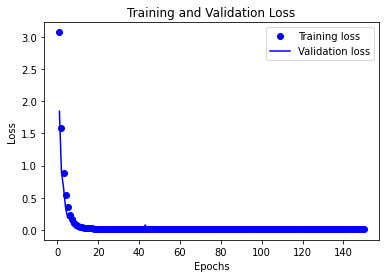

In [18]:

#################################################################################################
earlystopping_callback = EarlyStopping(monitor='val_loss',verbose=0,min_delta=0,patience=10,mode='auto', restore_best_weights=True)

# Train the Model
history = model.fit_generator(epochs =EpochNum,
                              generator=GenTrainData,
                              steps_per_epoch=np.ceil(train_number*subject_number/batch_size),
                              #callbacks=[earlystopping_callback],
                              validation_data=GenValidationData,
                              validation_steps =np.ceil(val_number*subject_number/batch_size),
                              use_multiprocessing=False,
                              workers=1)

#################################################################################################
# Evalute the Model
TrainResult      =model.evaluate_generator(GenTrainData,steps=np.ceil(train_number*subject_number/batch_size))
ValidationResult =model.evaluate_generator(GenValidationData,steps=np.ceil(val_number*subject_number/batch_size))
TestResult       =model.evaluate_generator(GenTestData,steps=np.ceil(test_number*subject_number/batch_size))
print('     TrainResult ([loss , acc])=',TrainResult)
print('ValidationResult ([loss , acc])=',ValidationResult)
print('      TestResult ([loss , acc])=',TestResult)

#################################################################################################
#################################################################################################
# save last model

lastmodelfileName = path +"_lastmodel"
model.save(lastmodelfileName)

##################################################################################################
# save history

historyFineName = path + "_myhistory_3bestch_Orth.npy"
np.save(historyFineName, history.history)
myhistory=np.load(historyFineName, allow_pickle='TRUE').item()

################################################################################################## 
# acc plot

acc_values = myhistory ['acc'] 
val_acc_values = myhistory['val_acc']
epochs = range(1, len(acc_values) + 1)

#plt.clf()
plt.plot(epochs, acc_values, 'bo', label='Training acc') 
plt.plot(epochs, val_acc_values, 'b', label='Validation acc') 
plt.title('Training and Validation Accuracy') 
plt.xlabel('Epochs') 
plt.ylabel('Accuracy') 
plt.legend()
#plt.show()
pdfNameAcc = path + "_Acc.pdf"
plt.savefig(pdfNameAcc)
plt.close()

#loss plot
history_dict = history.history 
loss_values = history_dict ['loss'] 
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss') 
plt.plot(epochs, val_loss_values, 'b', label='Validation loss') 
plt.title('Training and Validation Loss') 
plt.xlabel('Epochs') 
plt.ylabel('Loss') 
plt.legend()
#plt.show()
pdfNameLoss = path + "_Loss.pdf"
plt.savefig(pdfNameLoss)

Epoch 1/50
1496/1496 [==============================] - 33s 22ms/step - loss: 0.0141 - acc: 0.9981 - val_loss: 0.0019 - val_acc: 0.9994
Epoch 2/50
1496/1496 [==============================] - 33s 22ms/step - loss: 0.0147 - acc: 0.9979 - val_loss: 9.2402e-04 - val_acc: 0.9996
Epoch 3/50
1496/1496 [==============================] - 33s 22ms/step - loss: 0.0144 - acc: 0.9980 - val_loss: 0.0418 - val_acc: 0.9940
Epoch 4/50
1496/1496 [==============================] - 33s 22ms/step - loss: 0.0167 - acc: 0.9979 - val_loss: 5.3875e-04 - val_acc: 0.9998
Epoch 5/50
1496/1496 [==============================] - 34s 23ms/step - loss: 0.0138 - acc: 0.9981 - val_loss: 1.0401e-06 - val_acc: 1.0000
Epoch 6/50
1496/1496 [==============================] - 34s 23ms/step - loss: 0.0141 - acc: 0.9982 - val_loss: 2.2028e-04 - val_acc: 0.9999
Epoch 7/50
1496/1496 [==============================] - 33s 22ms/step - loss: 0.0144 - acc: 0.9983 - val_loss: 5.1413e-04 - val_acc: 0.9998
Epoch 8/50
1496/1496 [======

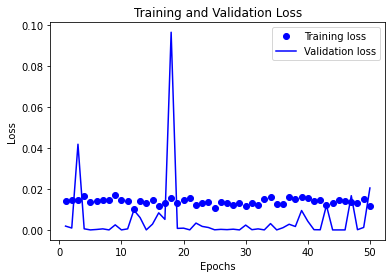

In [19]:

#################################################################################################
earlystopping_callback = EarlyStopping(monitor='val_loss',verbose=0,min_delta=0,patience=10,mode='auto', restore_best_weights=True)

# Train the Model
history = model.fit_generator(epochs =50,
                              generator=GenTrainData,
                              steps_per_epoch=np.ceil(train_number*subject_number/batch_size),
                              #callbacks=[earlystopping_callback],
                              validation_data=GenValidationData,
                              validation_steps =np.ceil(val_number*subject_number/batch_size),
                              use_multiprocessing=False,
                              workers=1)

#################################################################################################
# Evalute the Model
TrainResult      =model.evaluate_generator(GenTrainData,steps=np.ceil(train_number*subject_number/batch_size))
ValidationResult =model.evaluate_generator(GenValidationData,steps=np.ceil(val_number*subject_number/batch_size))
TestResult       =model.evaluate_generator(GenTestData,steps=np.ceil(test_number*subject_number/batch_size))
print('     TrainResult ([loss , acc])=',TrainResult)
print('ValidationResult ([loss , acc])=',ValidationResult)
print('      TestResult ([loss , acc])=',TestResult)

#################################################################################################
#################################################################################################
# save last model

lastmodelfileName = path +"_lastmodel2"
model.save(lastmodelfileName)

##################################################################################################
# save history

historyFineName = path + "_myhistory_3bestch_Orth_2.npy"
np.save(historyFineName, history.history)
myhistory=np.load(historyFineName, allow_pickle='TRUE').item()

################################################################################################## 
# acc plot

acc_values = myhistory ['acc'] 
val_acc_values = myhistory['val_acc']
epochs = range(1, len(acc_values) + 1)

#plt.clf()
plt.plot(epochs, acc_values, 'bo', label='Training acc') 
plt.plot(epochs, val_acc_values, 'b', label='Validation acc') 
plt.title('Training and Validation Accuracy') 
plt.xlabel('Epochs') 
plt.ylabel('Accuracy') 
plt.legend()
#plt.show()
pdfNameAcc = path + "_Acc2.pdf"
plt.savefig(pdfNameAcc)
plt.close()

#loss plot
history_dict = history.history 
loss_values = history_dict ['loss'] 
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss') 
plt.plot(epochs, val_loss_values, 'b', label='Validation loss') 
plt.title('Training and Validation Loss') 
plt.xlabel('Epochs') 
plt.ylabel('Loss') 
plt.legend()
#plt.show()
pdfNameLoss = path + "_Loss2.pdf"
plt.savefig(pdfNameLoss)